In [1]:
from lattice2d_linear_env import Lattice2DLinearEnv
import numpy as np
import math
import random

In [2]:
C = 1.41 # Constant in MCTS exploration
env = Lattice2DLinearEnv("HHPHPHHPPH")

### Node class

In [3]:
class MCTSNode():
    def __init__(self, state, parent = None):
        self.state = state # state = tuple of ele in (0,1,2) denoting actions taken thus far
        self.Q = 0 # Total reward
        self.N = 0 # Total times state is visited
        self.children = {} # Dict of children: Action : Child
        self.parent = parent # Parent of node
        self.score = 0.0 # score = average reward + exploration weight
        self.avg_Q = 0.0 # average reward
        
    def add_child(self, child, action):
        self.children.update( {action: child} )
    
    def update(self, Q):
        if self.parent != None:
            self.Q += Q
            self.N += 1
            self.score = self.Q / self.N + 2 * C * math.sqrt(2 * math.log(self.parent.N + 1) / self.N)
            self.avg_Q = self.Q / self.N
            self.parent.update(Q) 

## Main function for Monte Carlo Tree Search

In [4]:
def MCTS(root, max_iter):
    for i in range(max_iter):
        leaf = traverse(root)
        sim_result = rollout(leaf)
        leaf.update(sim_result)
        
    return best_action(root)

In [5]:
def traverse(node):
    '''
    Function for node traversal
    '''
    
    # While node is fully expanded, pick child with best score
    while len(list(node.children.keys())) == 3 and len(node.state) <= len(env.seq) - 1:
        node = best_uct(node)
        
    # If the node is terminal
    if len(node.state) == len(env.seq) - 1:
        return node
    
    # If not fully expanded, pick unvisited child.
    if len(list(node.children.values())) != 3: 
        unvisited = [a for a in range(3) if a not in list(node.children.keys())] # list of previously untaken actions
        action = random.choice(unvisited)
        child = MCTSNode(node.state + (action,), node)
        node.add_child(child, action)
        return child

In [6]:
def rollout(node):
    '''
    Function for simulating game starting from given node.
    Returns simulated reward
    '''
    trajectory = node.state
    while len(trajectory) != len(env.seq) - 1:
        trajectory += (random.choice(range(3)),) # simulate random policy until end of the game
    
    # Compute reward
    state = env.reset()
    a = 0
    reward = 0
    for i in range(len(trajectory)):
        _, reward, _, _ = env.step(a)
        a = (3 * a + trajectory[i]) % 4
    return reward

In [7]:
def best_action(node):
    '''
    Picks child with the highest average reward
    '''
    action = list(node.children.keys())[0]
    for i in list(node.children.keys()):
        if node.children[i].avg_Q > node.children[action].avg_Q:
            action = i
    return action

In [8]:
def best_uct(node):
    '''
    Picks child with the highest score
    '''
    child = node.children[0]
    for i in range(3):
        if node.children[i].score > child.score:
            child = node.children[i]
    return child

### Run MCTS Policy on environment

In [14]:
def run_MCTS_policy(root, best):
    state = env.reset()
    a = 0
    while True:
        _, reward, done, info = env.step(a)
        env.render()
        if done:
            print("Reward: {} | Actions: {}".format(reward, info['actions']))
            break
        best = best_action(root)
        root = root.children[best]
        a = (3 * a + best) % 4

In [10]:
root = MCTSNode(())
best = MCTS(root, 20000)

Reward: 4 | Actions: ['L', 'D', 'R', 'R', 'U', 'U', 'U', 'L', 'D']


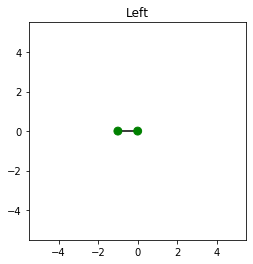

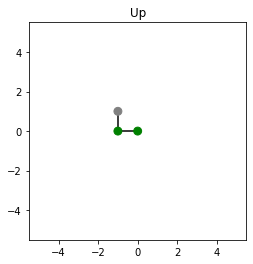

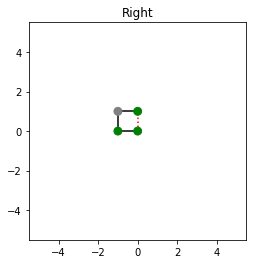

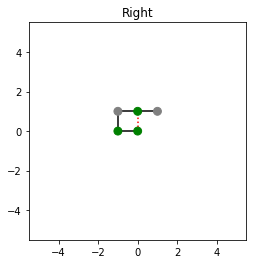

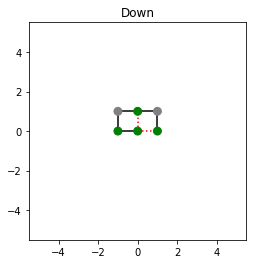

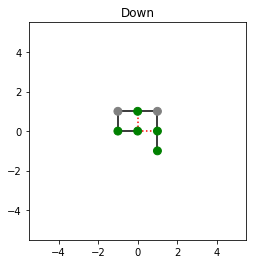

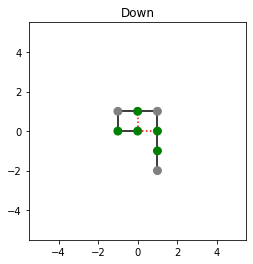

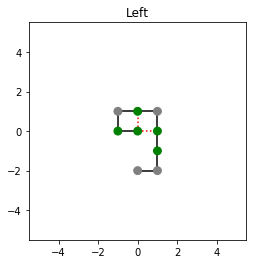

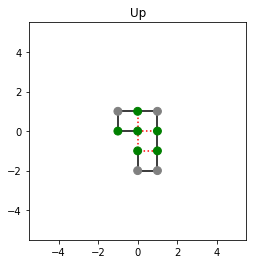

In [15]:
run_MCTS_policy(root, best)